In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk("data"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

os.environ["PYCARET_CUSTOM_LOGGING_LEVEL"] = "CRITICAL"
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from pycaret.time_series import *

color_pal = sns.color_palette()
plt.style.use("fivethirtyeight")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


data/petr_brent.csv
data/per-capita-energy-use.csv
data/oil-share-energy.csv
data/fossil-fuel-primary-energy.csv
data/fossil-fuel-consumption-by-type.csv
data/oil-production-by-country.csv
data/change-energy-consumption.csv
data/share-electricity-fossil-fuels.csv


In [2]:
data = pd.read_csv("data/petr_brent.csv")
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7600 entries, 0 to 7599
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE         7600 non-null   object 
 1   CODE         7600 non-null   object 
 2   RAW DATE     7600 non-null   object 
 3   DAY          7600 non-null   int64  
 4   MONTH        7600 non-null   int64  
 5   YEAR         7600 non-null   int64  
 6   VALUE (US$)  7459 non-null   float64
dtypes: float64(1), int64(3), object(3)
memory usage: 415.8+ KB


In [3]:
data.index = pd.to_datetime(data["DATE"])
start = data.index[0].date()
end = data.index[len(data) - 1].date()
new_dates = pd.date_range(start=start, end=end, freq="D")
data = data.reindex(new_dates)
data = data.rename_axis("DATE")
data["VALUE (US$)"] = data["VALUE (US$)"].interpolate().bfill()
data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8169 entries, 2002-01-01 to 2024-05-13
Freq: D
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE         7600 non-null   object 
 1   CODE         7600 non-null   object 
 2   RAW DATE     7600 non-null   object 
 3   DAY          7600 non-null   float64
 4   MONTH        7600 non-null   float64
 5   YEAR         7600 non-null   float64
 6   VALUE (US$)  8169 non-null   float64
dtypes: float64(4), object(3)
memory usage: 510.6+ KB


In [4]:
data.drop(["DATE", "CODE", "RAW DATE"], axis=1, inplace=True)
data.head()


,DAY,MONTH,YEAR,VALUE (US$)
DATE,,,,
2002-01-01,1.0,1.0,2002.0,20.13
2002-01-02,2.0,1.0,2002.0,20.13
2002-01-03,3.0,1.0,2002.0,20.47
2002-01-04,4.0,1.0,2002.0,21.20
2002-01-05,5.0,1.0,2002.0,21.16


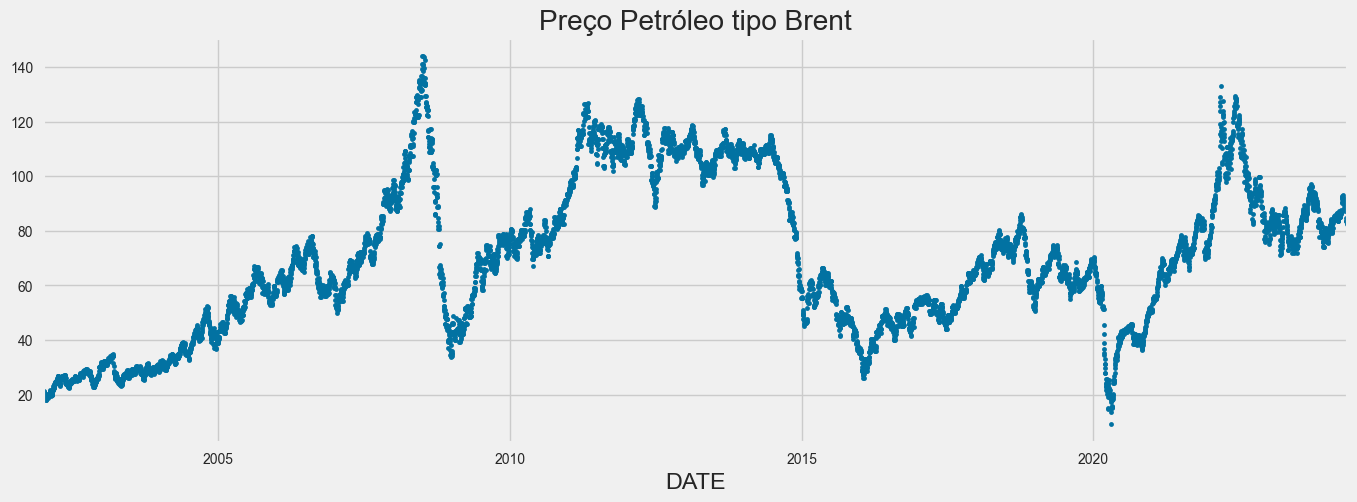

In [5]:
# df.plot(style='.', figsize=(15,5), color=color_pal[0], title = "PJME Energy Use in Mega walt (MW)");
data["VALUE (US$)"].plot(
    style=".", figsize=(15, 5), color=color_pal[0], title="Preço Petróleo tipo Brent"
)


In [6]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df["hour"] = df.index.hour
    df["dayofweek"] = df.index.day_of_week
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["dayofyear"] = df.index.day_of_year
    return df


df = create_features(data)


In [7]:
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8169 entries, 2002-01-01 to 2024-05-13
Freq: D
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DAY          7600 non-null   float64
 1   MONTH        7600 non-null   float64
 2   YEAR         7600 non-null   float64
 3   VALUE (US$)  8169 non-null   float64
 4   hour         8169 non-null   int32  
 5   dayofweek    8169 non-null   int32  
 6   quarter      8169 non-null   int32  
 7   month        8169 non-null   int32  
 8   year         8169 non-null   int32  
 9   dayofyear    8169 non-null   int32  
dtypes: float64(4), int32(6)
memory usage: 510.6 KB


In [8]:
df.drop(["DAY", "MONTH", "YEAR"], axis=1, inplace=True)
df.head()


,VALUE (US$),hour,dayofweek,quarter,month,year,dayofyear
DATE,,,,,,,
2002-01-01,20.13,0,1,1,1,2002,1
2002-01-02,20.13,0,2,1,1,2002,2
2002-01-03,20.47,0,3,1,1,2002,3
2002-01-04,21.20,0,4,1,1,2002,4
2002-01-05,21.16,0,5,1,1,2002,5


In [9]:
df = df.loc["2016-01-01":]
fh = int(len(df) * 0.15)


# Experimento com o modelo univariado

In [10]:
df_uni = df["VALUE (US$)"]


In [11]:
experiment_uni = TSForecastingExperiment()
experiment_uni.setup(
    data=df_uni,
    target="VALUE (US$)",
    fh=fh,
    fold=3,
    use_gpu=True,
    scale_target="maxabs",
)


,Description,Value
0,session_id,7891
1,Target,VALUE (US$)
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(3056, 1)"
5,Transformed data shape,"(3056, 1)"
6,Transformed train set shape,"(2598, 1)"
7,Transformed test set shape,"(458, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters mi

[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters mi

[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with

In [13]:
experiment_uni.plot_model()


In [14]:
experiment_uni.plot_model(data_kwargs={"plot_data_type": ["transformed"]})


In [15]:
experiment_uni.plot_model(plot="diagnostics", fig_kwargs={"height": 800, "width": 1000})


In [16]:
experiment_uni.plot_model(
    plot="diff",
    data_kwargs={
        "lags_list": [[1], [1, 16]],
        "acf": True,
        "pacf": True,
        "periodogram": True,
    },
    fig_kwargs={"height": 800, "width": 1500},
)


In [17]:
experiment_uni.plot_model(
    plot="train_test_split", fig_kwargs={"height": 400, "width": 900}
)


In [18]:
experiment_uni.plot_model(plot="decomp_stl", fig_kwargs={"height": 400, "width": 900})


In [19]:
experiment_uni.check_stats()


,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,3056.0
1,Summary,Statistics,Transformed,# Missing Values,,0.0
2,Summary,Statistics,Transformed,Mean,,0.502487
3,Summary,Statistics,Transformed,Median,,0.499137
4,Summary,Statistics,Transformed,Standard Deviation,,0.153088
5,Summary,Statistics,Transformed,Variance,,0.023436
6,Summary,Statistics,Transformed,Kurtosis,,0.146381
7,Summary,Statistics,Transformed,Skewness,,0.295069
8,Summary,Statistics,Transformed,# Distinct Values,,2361.0
9,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",68749.304562


In [20]:
include = [
    "ridge_cds_dt",
    "arima",
    "huber_cds_dt",
    "lightgbm_cds_dt",
    "knn_cds_dt",
    "gbr_cds_dt",
    "br_cds_dt",
    "dt_cds_dt",
    "rf_cds_dt",
    "ada_cds_dt",
    "prophet",
    "omp_cds_dt",
    "xgboost_cds_dt",
]
exclude = ["auto_arima", "bats", "tbats", "lar_cds_dt", "par_cds_dt"]


In [1]:
metric = "mape"
best = experiment_uni.compare_models(
    n_select=5, include=include, sort=metric, turbo=True
)


NameError: name 'experiment' is not defined

In [79]:
compare_metrics = experiment_uni.pull()


In [80]:
compare_metrics


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
croston,Croston,4.5339,4.3205,17.8682,22.5072,0.3411,0.2831,-1.269,0.1333
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,4.6689,4.4274,17.8769,21.9659,0.3908,0.2563,-1.533,27.7867
arima,ARIMA,5.0171,4.6691,19.4158,23.5932,0.4068,0.2906,-1.6482,7.7633
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasona...,5.0769,4.7133,19.5736,23.6446,0.4058,0.28,-1.7697,27.9100
et_cds_dt,Extra Trees w/ Cond. Deseasonalize & Detrending,5.1311,4.8374,19.9565,24.6681,0.4063,0.3029,-1.8006,32.4667
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,5.132,4.8267,19.9497,24.5961,0.4065,0.3021,-1.788,34.9933
ada_cds_dt,AdaBoost w/ Cond. Deseasonalize & Detrending,5.2237,4.8808,20.3337,24.9519,0.4089,0.3103,-1.8521,31.7633
dt_cds_dt,Decision Tree w/ Cond. Deseasonalize & Detrending,5.3056,5.3366,20.7896,27.2915,0.4134,0.3048,-2.3786,27.8600
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize...,5.5308,5.1697,21.4194,26.1795,0.4434,0.3186,-2.2384,28.1133
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detren...,5.6088,5.1717,21.9612,26.6229,0.4168,0.3245,-2.1836,27.6467


In [81]:
compare_metrics.to_csv("compare_metrics.csv")


In [82]:
experiment_uni.plot_model(best, plot="forecast")


In [83]:
ridge_cds_dt_model = experiment_uni.create_model("ridge_cds_dt")


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2019-05-08,7.1033,7.1329,25.8285,32.3246,0.7835,0.4300,-3.1607
1,2020-08-08,3.9062,3.3781,16.3239,19.7036,0.2399,0.2796,-0.9609
2,2021-11-09,5.8787,5.0627,23.9869,28.1838,0.2317,0.2707,-2.4840
Mean,NaT,5.6294,5.1912,22.0464,26.7373,0.4184,0.3268,-2.2019
SD,NaT,1.3171,1.5356,4.1157,5.2530,0.2582,0.0731,0.9200


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pycaret/time_series/forecasting/oop.py:2694: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



In [ ]:
experiment_uni.plot_model(prophet_model)


In [85]:
prophet_model = experiment_uni.create_model("prophet")


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2019-05-08,5.0708,5.2604,18.4379,23.8391,0.5737,0.3435,-1.2630
1,2020-08-08,11.9946,9.7030,50.1256,56.5958,0.7522,1.3112,-15.1782
2,2021-11-09,4.4024,4.1385,17.9631,23.0386,0.1995,0.1746,-1.3280
Mean,NaT,7.1559,6.3673,28.8422,34.4912,0.5085,0.6098,-5.9231
SD,NaT,3.4323,2.4028,15.0509,15.6337,0.2303,0.5008,6.5444


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pycaret/time_series/forecasting/oop.py:2694: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



In [86]:
experiment_uni.plot_model(prophet_model)


In [ ]:
best_tuned_models = [experiment_uni.tune_model(model) for model in best]


In [ ]:
blender = experiment_uni.blend_models(
    best_tuned_models, method="gmean", optimize="MAPE"
)
